# <font color='red'>**Sequence to sequence implementation**</font>

In [2]:
!pip install contractions

     |████████████████████████████████| 266kB 4.3MB/s 
     |████████████████████████████████| 327kB 6.1MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.1-cp36-cp36m-linux_x86_64.whl size=84341 sha256=451388d2cc4a028631e4bea9d2a3b86a8dc4ccc2737c3080cf0ae11bc93eb054
  Stored in directory: /root/.cache/pip/wheels/e4/ab/f7/cb39270df8f6126f3dd4c33d302357167086db460968cfc80c
Successfully built pyahocorasick


**There will be some functions that start with the word "grader" ex: grader_check_encoder(), grader_check_attention(), grader_onestepdecoder() etc, you should not change those function definition.<br><br>Every Grader function has to return True.**

**Note 1:**  There are many blogs on the attention mechanisum which might be misleading you,
 so do read the references completly and after that only please check the internet.
 The best things is to read the research papers and try to implement it on your own. 

**Note 2:** To complete this assignment, the reference that are mentioned will be enough.

**Note 3:** If you are starting this assignment, you might have completed minimum of 20 assignment.
 If  you are still not able to implement this algorithm you might have rushed in the previous assignments 
with out learning much and didn't spend your time productively.

## Task -1: Simple Encoder and Decoder
Implement simple Encoder-Decoder model

1. Download the **Italian** to **English** translation dataset from <a href="http://www.manythings.org/anki/ita-eng.zip">here</a>

2. You will find **ita.txt** file in that ZIP, 
you can read that data using python and preprocess that data this way only: 
<img src='https://i.imgur.com/z0j79Jf.png'>    
    
3. You have to implement a simple Encoder and Decoder architecture  

4. Use BLEU score as metric to evaluate your model. You can use any loss function you need.

5. You have to use Tensorboard to plot the Graph, Scores and histograms of gradients. 

6.  a. Check the reference notebook <br>
    b. <a href="https://medium.com/analytics-vidhya/understand-sequence-to-sequence-models-in-a-more-intuitive-way-1d517d8795bb">Resource 2</a>

<font color='red'>**Load the data**</font>

In [3]:
import tensorflow as tf
import warnings
import pandas as pd
from tqdm import tqdm
import contractions
import re
import numpy as np

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
warnings.filterwarnings('ignore')
data = open('ita.txt', 'r', encoding = 'utf-8').read().split('\n')
print(len(data))

343814


In [5]:
data_f = []
for i in range(100000):
    try:
        english, italin = data[i].split('\t')[0:2]
        data_f.append([english, italin])
    except:
        pass
data_f = pd.DataFrame(data_f, columns = ['english', 'italin'])
data_f.head()

,english,italin
0,Hi.,Ciao!
1,Run!,Corri!
2,Run!,Corra!
3,Run!,Correte!
4,Who?,Chi?


<font color='red'>**Preprocess data**</font>

In [6]:
"""Ref: https://www.geeksforgeeks.org/nlp-expand-contractions-in-txt-processing/"""
def preprocess(txt):
    txt = txt.lower()
    for a, b in enumerate(txt.split()):
        try:
            if len(re.findall('[^\w\d\ "]', b))> 0:
                txt = re.sub(b, contractions.fix(b), txt)    
            txt = re.sub('[^A-Za-z0-9èìò ]+', '', txt)
        except:
            return np.nan
    return txt

dat_eng = data_f.english.astype('str').apply(lambda x: preprocess(x))
dat_ita = data_f.italin.astype('str').apply(lambda x: preprocess(x))
data_preprocessing = pd.DataFrame(data = np.array([dat_eng, dat_ita]).T, columns = ['english', 'italin'])

## <font color='red'>**Implement custom encoder decoder**</font>
<font color='red'>**Encoder**</font>

In [7]:
from tensorflow.keras.layers import Embedding, LSTM, Dense
import tensorflow as tf
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''
    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()
        self.lstm_size = lstm_size
        #Initialize Embedding layer
        self.enc_embed = Embedding(input_dim = inp_vocab_size, output_dim = embedding_size, input_length= input_length)
        #Intialize Encoder LSTM layer
        self.enc_lstm = LSTM(lstm_size, return_sequences = True, return_state = True)

    def call(self,input_sequence,states):
        embedding = self.enc_embed(input_sequence)
        output_state, enc_h, enc_c = self.enc_lstm(embedding, initial_state = states)
        return output_state, enc_h, enc_c      

    def initialize_states(self,batch_size):
        return [tf.zeros((batch_size, self.lstm_size)), tf.zeros((batch_size, self.lstm_size))]

# Ref: https://vineethaswani2.medium.com/spelling-error-correction-7154f781354c
![](encoder.png)

<font color='orange'>**Grader function - 1**</font>

In [8]:
def grader_check_encoder():
    '''
        vocab-size: Unique words of the input language,
        embedding_size: output embedding dimension for each word after embedding layer,
        lstm_size: Number of lstm units,
        input_length: Length of the input sentence,
        batch_size
    '''
    vocab_size=10
    embedding_size=20
    lstm_size=32
    input_length=10
    batch_size=16
    #Intialzing encoder 
    encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
    input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
    #Intializing encoder initial states
    initial_state=encoder.initialize_states(batch_size)
    
    encoder_output,state_h,state_c=encoder(input_sequence,initial_state)
    
    assert(encoder_output.shape==(batch_size,input_length,lstm_size) and state_h.shape==(batch_size,lstm_size) and state_c.shape==(batch_size,lstm_size))
    return True
print(grader_check_encoder())

True


In [9]:
class Decoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''
    def __init__(self,out_vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()
        #Initialize Embedding layer
        self.dec_embed = Embedding(input_dim = out_vocab_size, output_dim = embedding_size, input_length = input_length)
        #Intialize Decoder LSTM layer
        self.dec_lstm = LSTM(lstm_size, return_sequences = True, return_state = True)

    def call(self,input_sequence,initial_states):
        embedding = self.dec_embed(input_sequence)
        output_state, dec_h, dec_c = self.dec_lstm(embedding, initial_state = initial_states)
        return output_state, dec_h, dec_c     

# Ref: https://vineethaswani2.medium.com/spelling-error-correction-7154f781354c
![](decoder.png)

<font color='orange'>**Grader function - 2**</font>

In [10]:
def grader_decoder():
    '''
        out_vocab_size: Unique words of the target language,
        embedding_size: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        input_length: Length of the input sentence,
        batch_size
        
    
    '''
    out_vocab_size=13 
    embedding_dim=12 
    input_length=10
    dec_units=16 
    batch_size=32
    
    target_sentences=tf.random.uniform(shape=(batch_size,input_length),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    states=[state_h,state_c]
    decoder=Decoder(out_vocab_size, embedding_dim, dec_units,input_length )
    output,_,_=decoder(target_sentences, states)
    assert(output.shape==(batch_size,input_length,dec_units))
    return True
print(grader_decoder())

True


In [11]:
class Encoder_decoder(tf.keras.Model): 
    def __init__(self,*params):
        super().__init__()
        #Create encoder object
        self.encoder = Encoder(inp_vocab_size = params[0], embedding_size = params[2], lstm_size = params[3], input_length = params[4])
        #Create decoder object
        self.decoder = Decoder(out_vocab_size = params[1], embedding_size = params[2], lstm_size = params[3], input_length = params[5])
        #Intialize Dense layer(out_vocab_size) with activation='softmax'
        self.dense = Dense(params[1], activation='softmax')
    
    @tf.function
    def call(self, params, training = True):

        enc_inp, dec_inp = params[0], params[1]
        initial_state = self.encoder.initialize_states(batch_size)
        output_state, enc_h, enc_c = self.encoder(enc_inp, initial_state)
        output, _, _ = self.decoder(dec_inp ,[enc_h, enc_c])
        return self.dense(output)

# Ref: https://vineethaswani2.medium.com/spelling-error-correction-7154f781354c
![](Encoder_decoder.png)

In [12]:
data_preprocessing['english_inp'] = '<sos> '+data_preprocessing['english']
data_preprocessing['english_out'] = data_preprocessing['english'] + ' <eos>'
data_preprocessing['italin'] = data_preprocessing['italin'].apply(lambda x: str(x))
data_preprocessing['italin'] = '<sos> '+data_preprocessing['italin']+' <eos>'

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_preprocessing, test_size = 0.1, random_state = 0)
train, validation = train_test_split(train, test_size = 0.1, random_state = 0)

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer_italian = Tokenizer()
tokenizer_italian.fit_on_texts(train['italin'].values)
tokenizer_english = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tokenizer_english.fit_on_texts(train['english_inp'].values + train['english_out'].values)

In [14]:
eng_vc_len = data_preprocessing['italin'].astype(str).apply(lambda x: len(x))
ita_vc_len = data_preprocessing['english_inp'].astype(str).apply(lambda x: len(x))

In [15]:
for i in range(0,101,10):
    print(i,np.percentile(eng_vc_len, i))
for i in range(90,101):
    print(i,np.percentile(eng_vc_len, i))
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(eng_vc_len, i))

0 12.0
10 24.0
20 26.0
30 28.0
40 29.0
50 31.0
60 32.0
70 34.0
80 35.0
90 38.0
100 112.0
90 38.0
91 38.0
92 39.0
93 39.0
94 40.0
95 40.0
96 41.0
97 42.0
98 43.0
99 45.0
100 112.0
99.1 45.0
99.2 46.0
99.3 46.0
99.4 46.0
99.5 47.0
99.6 48.0
99.7 48.0
99.8 49.0
99.9 51.00100000000384
100 112.0


In [16]:
for i in range(0,101,10):
    print(i,np.percentile(ita_vc_len, i))
for i in range(90,101):
    print(i,np.percentile(ita_vc_len, i))
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(ita_vc_len, i))

0 8.0
10 18.0
20 20.0
30 21.0
40 22.0
50 23.0
60 24.0
70 25.0
80 25.0
90 26.0
100 43.0
90 26.0
91 26.0
92 26.0
93 26.0
94 26.0
95 27.0
96 27.0
97 27.0
98 27.0
99 28.0
100 43.0
99.1 28.0
99.2 28.0
99.3 28.0
99.4 28.0
99.5 28.0
99.6 28.0
99.7 28.0
99.8 29.0
99.9 29.0
100 43.0


In [17]:
eng_voc_len = 0
set_eng = set()
for i in data_preprocessing['english_inp'].values+data_preprocessing['english_out'].values:
    x = len(i.split())
    if x > eng_voc_len:
        eng_voc_len = x
    for j in i.split():
        set_eng.add(j)
set_eng_size = len(set_eng)

ita_voc_len = 0
set_ita = set()
for i in data_preprocessing['italin']:
    x = len(i.split())
    if x > ita_voc_len:
        ita_voc_len = x
    for j in i.split():
        set_ita.add(j)
set_ita_size = len(set_ita)

In [18]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

"""Ref: https://gist.github.com/ashishthomaschempolil/3539a83449645391328e4694b177b18a"""
class Dataset:
    def __init__(self, data, tokenizer_italian, tokenizer_english, ita_voc_len, eng_voc_len):
        self.encd_inputs = data['italin'].values
        self.decd_inputs = data['english_inp'].values
        self.decd_outputs = data['english_out'].values
        self.tokenizer_english = tokenizer_english
        self.tokenizer_italian = tokenizer_italian
        self.ita_voc_len = ita_voc_len
        self.eng_voc_len = eng_voc_len

    def __getitem__(self, i):
        self.encd_sequence = self.tokenizer_italian.texts_to_sequences([self.encd_inputs[i]]) # need to pass list of values
        self.decd_input_sequence = self.tokenizer_english.texts_to_sequences([self.decd_inputs[i]])
        self.decd_output_sequence = self.tokenizer_english.texts_to_sequences([self.decd_outputs[i]])

        self.encd_sequence = pad_sequences(self.encd_sequence, maxlen=self.ita_voc_len, dtype='int32', padding='post')
        self.decd_input_sequence = pad_sequences(self.decd_input_sequence, maxlen=self.eng_voc_len, dtype='int32', padding='post')
        self.decd_output_sequence = pad_sequences(self.decd_output_sequence, maxlen=self.eng_voc_len, dtype='int32', padding='post')
        return self.encd_sequence, self.decd_input_sequence, self.decd_output_sequence

    def __len__(self): 
        return len(self.encd_inputs)

"""Ref: https://gist.github.com/ashishthomaschempolil/60277e4ca6e7541dc96ef195fd5b839e"""
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encd_inputs))

    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        return tuple([[tf.convert_to_tensor(batch[0]), tf.convert_to_tensor(batch[1])], tf.convert_to_tensor(batch[2])])

    def __len__(self):  
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [19]:
"""Ref: https://ppasumarthi-69210.medium.com/word-embeddings-in-keras-be6bb3092831"""
embeddings_index = dict()
f = open('glove.6B.300d.txt', encoding = 'utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


![](emb_mat.png)

In [20]:
"""Ref: https://ppasumarthi-69210.medium.com/word-embeddings-in-keras-be6bb3092831"""
embedding_matrix = np.zeros((eng_vocab_size, 300))
for word, i in tokenizer_english.word_index.items():
    embedding_vector = embeddings_index.get(ord)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

![](emb_mat_2.png)

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
import os
import datetime
batch_size=32
lstm_size=128
eng_voc_len = 50
ita_txt_len = 29
embedding_dim = 300
dense_units = 256

tr_dat = Dataset(train, tokenizer_italian, tokenizer_english, ita_txt_len, eng_voc_len)
te_dat  = Dataset(test, tokenizer_italian, tokenizer_english, ita_txt_len, eng_voc_len)
val_dat  = Dataset(validation, tokenizer_italian, tokenizer_english, ita_txt_len, eng_voc_len)

train_dataloader = Dataloder(tr_dat, batch_size=batch_size)
test_dataloader = Dataloder(te_dat, batch_size=batch_size)
val_dataloader = Dataloder(val_dat, batch_size = batch_size)

In [23]:
model = Encoder_decoder(set_ita_size, set_eng_size, embedding_dim, lstm_size, ita_txt_len, eng_voc_len, dense_units)
model.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy')
log_dir="logs/seq2seq/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
call_back = [ModelCheckpoint('ita_eng_1', save_best_only= True, verbose = 1),TensorBoard(log_dir = log_dir, 
                              histogram_freq=1, write_graph=True), EarlyStopping(patience = 5, verbose = 1),
                              ReduceLROnPlateau(patience = 3, verbose = 1)]

model.fit(x = train_dataloader, steps_per_epoch = train_dataloader.__len__(),
          validation_data = val_dataloader, validation_steps = val_dataloader.__len__(),
          epochs = 35, verbose = 1, callbacks = call_back)

Epoch 1/35
2531/2531 [==============================] - 275s 108ms/step - loss: 0.9992 - val_loss: 0.3312

Epoch 00001: val_loss improved from inf to 0.33121, saving model to ita_eng_1
Epoch 2/35
2531/2531 [==============================] - 273s 108ms/step - loss: 0.3164 - val_loss: 0.2709

Epoch 00002: val_loss improved from 0.33121 to 0.27088, saving model to ita_eng_1
Epoch 3/35
2531/2531 [==============================] - 278s 110ms/step - loss: 0.2514 - val_loss: 0.2185

Epoch 00003: val_loss improved from 0.27088 to 0.21847, saving model to ita_eng_1
Epoch 4/35
2531/2531 [==============================] - 278s 110ms/step - loss: 0.1987 - val_loss: 0.1833

Epoch 00004: val_loss improved from 0.21847 to 0.18326, saving model to ita_eng_1
Epoch 5/35
2531/2531 [==============================] - 278s 110ms/step - loss: 0.1594 - val_loss: 0.1531

Epoch 00005: val_loss improved from 0.18326 to 0.15313, saving model to ita_eng_1
Epoch 6/35
2531/2531 [==============================] - 279

In [24]:
class pred_Encoder_decoder(tf.keras.Model): 
    def __init__(self,*params):
        super().__init__()
        self.encoder = Encoder(inp_vocab_size = params[0], embedding_size = params[2], lstm_size = params[3], input_length = params[4])
        self.decoder = Decoder(out_vocab_size = params[1], embedding_size = params[2], lstm_size = params[3], input_length = params[5])
        self.dense = Dense(params[1], activation='softmax')
    
    def call(self, params, training = True):
        enc_inp = params[0]
        initial_state = self.encoder.initialize_states(1)
        output_state, enc_h, enc_c = self.encoder(enc_inp, initial_state)
        pred = tf.expand_dims([tokenizer_english.word_index['<sos>']], 0)
        dec_h = enc_h
        dec_c = enc_c
        all_pred = []
        for t in range(eng_voc_len):  
            pred, dec_h,dec_c = self.decoder(pred, [dec_h, dec_c])
            pred = self.dense(pred)
            pred = tf.argmax(pred, axis = -1)
            all_pred.append(pred)
        return all_pred

Ref: https://vineethaswani2.medium.com/spelling-error-correction-7154f781354c
![](pred_Encoder_decoder.png)

In [25]:
final_output = pred_Encoder_decoder(set_ita_size, set_eng_size, embedding_dim, lstm_size, ita_txt_len, eng_voc_len, dense_units)
final_output.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy')
final_output.load_weights('/content/ita_eng_1')

In [26]:
def predict(input_sequence):
    x = preprocess(input_sequence)
    x = '<sos> '+x+' <eos>'
    x = tokenizer_italian.texts_to_sequences([x])
    x = pad_sequences(seq, maxlen=ita_txt_len, padding='post', dtype = np.int32)
    y = final_output.predict(tf.expand_dims(seq, 0))
    z = []
    for i in y:
        word = tokenizer_english.index_word[i[0][0]]
        if word == '<eos>':
            break
        z.append(word)
    return ' '.join(z)   

In [27]:
pr_final = train['italin'].values[0][6:-6]
print('input : ', pr_final)
result = predict(pr_final)
print('predicted output : ',result)
print('actual output :', train['english'].values[0])

input :  ha appena chiamato qualcuno
predicted output :  somebody just called
actual output : somebody just called


In [28]:
pr_final = train['italin'].values[1000][6:-6]
print('input : ', pr_final)
result = predict(pr_final)
print('predicted output : ',result)
print('actual output :', train['english'].values[1000])

input :  io ero gelosa di voi
predicted output :  i was jealous of you
actual output : i was jealous of you


In [29]:
from nltk.translate.bleu_score import sentence_bleu
initial =0
for i in range(1000):
    pr_final = test['italin'].values[i][6:-6]
    con = test['english'].values[i]
    pred = predict(pr_final)
    initial+= sentence_bleu([con.split()], pred.split())
print('Bleu Score : {}'.format(score/1000))

Bleu Score : 0.8391122289889017


## Task -2: Including Attention mechanisum

1. Use the preprocessed data from Task-1

2. You have to implement an Encoder and Decoder architecture with  
attention as discussed in the reference notebook.

    * Encoder   - with 1 layer LSTM <br>
    * Decoder   - with 1 layer LSTM<br>
    * attention -  (Please refer the <a href= 'https://drive.google.com/file/d/1z_bnc-3aubKawbR6q8wyI6Mh5ho2R1aZ/view?usp=sharing'>**reference notebook**</a> to know more about the attention mechanism.)
3. In Global attention, we have 3 types of scoring functions(as discussed in the reference notebook).
 As a part of this assignment **you need to create 3 models for each scoring function**
<img src='https://i.imgur.com/iD2jZo3.png'>

    * In model 1 you need to implemnt "dot" score function
    * In model 2 you need to implemnt "general" score function
    * In model 3 you need to implemnt "concat" score function.<br>
    
 **Please do add the markdown titles for each model so that we can have a better look at the code and verify.**
4. It is mandatory to train the model with simple model.fit() only, Donot train the model with custom GradientTape()

5. Using attention weights, you can plot the attention plots, 
please plot those for 2-3 examples. You can check about those in <a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate">this</a>

6. The attention layer has to be written by yourself only. 
The main objective of this assignment is to read and implement a paper on yourself so please do it yourself.  

7. Please implement the class **onestepdecoder** as mentioned in the assignment instructions.

8. You can use any tf.Keras highlevel API's to build and train the models. 
 Check the reference notebook for better understanding.

9. Use BLEU score as metric to evaluate your model. You can use any loss function you need.

10. You have to use Tensorboard to plot the Graph, Scores and histograms of gradients. 

11. Resources:
    a. Check the reference notebook
    b. <a href="https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/">Resource 1</a>
    c. <a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention">Resource 2</a>
    d. <a href="https://stackoverflow.com/questions/44238154/what-is-the-difference-between-luong-attention-and-bahdanau-attention#:~:text=Luong%20attention%20used%20top%20hidden,hidden%20state%20at%20time%20t.">Resource 3</a>
    
    
### <font color='red'>**Implement custom encoder decoder and attention layers**</font>
<font color='red'>**Encoder**</font>

In [30]:
from tensorflow.keras.layers import *
class Encoder(tf.keras.Model):

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        super(Encoder, self).__init__()
        self.lstm_size = lstm_size
        self.enc_embed = Embedding(input_dim = inp_vocab_size, output_dim = embedding_size)
        self.enc_lstm = LSTM(lstm_size, return_sequences = True, return_state = True)
        
    def call(self,input_sequence,states):
        embedding = self.enc_embed(input_sequence)
        output_state, enc_h, enc_c = self.enc_lstm(embedding, initial_state = states)
        return output_state, enc_h, enc_c
    
    def initialize_states(self,batch_size):
        return [tf.zeros((batch_size, self.lstm_size)), tf.zeros((batch_size, self.lstm_size))]

Ref: https://vineethaswani2.medium.com/spelling-error-correction-7154f781354c
![](encoder.png)

<font color='cyan'>**Grader function - 1**</font>

In [31]:
def grader_check_encoder():
    
    '''
        vocab-size: Unique words of the input language,
        embedding_size: output embedding dimension for each word after embedding layer,
        lstm_size: Number of lstm units in encoder,
        input_length: Length of the input sentence,
        batch_size
    '''
    
    vocab_size=10
    embedding_size=20
    lstm_size=32
    input_length=10
    batch_size=16
    encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
    input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
    initial_state=encoder.initialize_states(batch_size)
    encoder_output,state_h,state_c=encoder(input_sequence,initial_state)
    
    assert(encoder_output.shape==(batch_size,input_length,lstm_size) and state_h.shape==(batch_size,lstm_size) and state_c.shape==(batch_size,lstm_size))
    return True
print(grader_check_encoder())

True


<font color='cyan'>**Attention**</font>

In [32]:
from tensorflow.keras.layers import *
class Attention(tf.keras.layers.Layer):

    def __init__(self,scoring_function, att_units):
        super(Attention, self).__init__()
        self.scoring_function = scoring_function
        if scoring_function == 'dot':
            self.dot = Dot(axes = (1, 2))
        elif scoring_function == 'general':
            self.W = Dense(att_units)
            self.dot = Dot(axes = (1, 2))
        elif scoring_function == 'concat':
            self.W1 = Dense(att_units)
            self.W2 = Dense(att_units)
            self.V = Dense(1)
    def call(self,decoder_hidden_state,encoder_output):
    
        decoder_hidden_state = tf.expand_dims(decoder_hidden_state, 1)
        
        if self.scoring_function == 'dot':
            score = tf.transpose(self.dot([tf.transpose(decoder_hidden_state, (0, 2, 1)), encoder_output]), (0, 2,1))
            
        elif self.scoring_function == 'general':
            mul = self.W(encoder_output)
            score = tf.transpose(self.dot([tf.transpose(decoder_hidden_state, (0, 2, 1)), mul]), (0, 2,1))
            
        elif self.scoring_function == 'concat':
            inter = self.W1(decoder_hidden_state) + self.W2(encoder_output)
            tan = tf.nn.tanh(inter)
            score = self.V(tan)
        attention_weights = tf.nn.softmax(score, axis =1)
        context_vector = attention_weights * encoder_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

Ref: https://vineethaswani2.medium.com/spelling-error-correction-7154f781354c
![](Attention.png)

<font color='cyan'>**Grader function - 2**</font>

In [33]:
def grader_check_attention(scoring_fun):
    
    ''' 
        att_units: Used in matrix multiplications for scoring functions,
        input_length: Length of the input sentence,
        batch_size
    '''
    
    input_length=10
    batch_size=16
    att_units=32
    
    state_h=tf.random.uniform(shape=[batch_size,att_units])
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,att_units])
    attention=Attention(scoring_fun,att_units)
    context_vector,attention_weights=attention(state_h,encoder_output)
    assert(context_vector.shape==(batch_size,att_units) and attention_weights.shape==(batch_size,input_length,1))
    return True
print(grader_check_attention('dot'))
print(grader_check_attention('general'))
print(grader_check_attention('concat'))

True
True
True


<font color='red'>**OneStepDecoder**</font>

In [34]:
class OneStepDecoder(tf.keras.layers.Layer):
    def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
        super(OneStepDecoder, self).__init__()
        self.embed_dec = Embedding(input_dim = tar_vocab_size, output_dim = embedding_dim)
        self.lstm = LSTM(dec_units, return_sequences = True, return_state = True)
        self.attention = Attention(scoring_function = score_fun, att_units = att_units)
        self.fc = Dense(tar_vocab_size)
    
    def call(self,input_to_decoder, encoder_output, state_h,state_c):
        embed = self.embed_dec(input_to_decoder)
        context_vect, attention_weights = self.attention(state_h, encoder_output)    
        final_inp = tf.concat([tf.expand_dims(context_vect, 1), embed], axis = -1)
        out, dec_h, dec_c = self.lstm(final_inp, [state_h, state_c])
        out = tf.reshape(out, (-1, out.shape[2]))
        output = self.fc(out)
        return output, dec_h, dec_c, attention_weights, context_vect

Ref: https://vineethaswani2.medium.com/spelling-error-correction-7154f781354c
![](OneStepDecoder.png)

<font color='cyan'>**Grader function - 3**</font>

In [35]:
def grader_onestepdecoder(score_fun):
    
    tar_vocab_size=13 
    embedding_dim=12 
    input_length=10
    dec_units=16 
    att_units=16
    batch_size=32
    onestepdecoder=OneStepDecoder(tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
    input_to_decoder=tf.random.uniform(shape=(batch_size,1),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    output,state_h,state_c,attention_weights,context_vector=onestepdecoder(input_to_decoder,encoder_output,state_h,state_c)
    assert(output.shape==(batch_size,tar_vocab_size))
    assert(state_h.shape==(batch_size,dec_units))
    assert(state_c.shape==(batch_size,dec_units))
    assert(attention_weights.shape==(batch_size,input_length,1))
    assert(context_vector.shape==(batch_size,dec_units))
    return True
    
print(grader_onestepdecoder('dot'))
print(grader_onestepdecoder('general'))
print(grader_onestepdecoder('concat'))

True
True
True


<font color='red'>**Decoder**</font>

In [36]:

class Decoder(tf.keras.layers.Layer):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
        super(Decoder, self).__init__()
        self.input_length = input_length
        self.out_vocab_size = out_vocab_size
        self.one_step_decoder = OneStepDecoder(out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
        self.out_vocab_size = out_vocab_size
        
    def call(self, input_to_decoder, encoder_output, decoder_hidden_state, decoder_cell_state):
        all_outputs = tf.TensorArray(dtype = tf.float32, size= input_to_decoder.shape[1])
        
        for timestep in range(input_to_decoder.shape[1]):
            output, decoder_hidden_state, decoder_cell_state, _, _ = self.one_step_decoder(input_to_decoder[:, timestep:timestep+1], 
                                                                                             encoder_output, 
                                                                                             decoder_hidden_state,
                                                                                             decoder_cell_state)
            all_outputs = all_outputs.write(timestep, output)
        all_outputs = tf.transpose(all_outputs.stack(), (1, 0, 2))
        return all_outputs

Ref: https://vineethaswani2.medium.com/spelling-error-correction-7154f781354c

<font color='cyan'>**Grader function - 4**</font>

In [37]:
def grader_decoder(score_fun):
    
    '''
        out_vocab_size: Unique words of the target language,
        embedding_dim: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        att_units: Used in matrix multiplications for scoring functions in attention class,
        input_length: Length of the target sentence,
        batch_size
        
    
    '''
    
    out_vocab_size=13 
    embedding_dim=12 
    input_length=11
    dec_units=16 
    att_units=16
    batch_size=32
    
    target_sentences=tf.random.uniform(shape=(batch_size,input_length),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    
    decoder=Decoder(out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
    output=decoder(target_sentences,encoder_output, state_h, state_c)
    assert(output.shape==(batch_size,input_length,out_vocab_size))
    return True
print(grader_decoder('dot'))
print(grader_decoder('general'))
print(grader_decoder('concat'))

True
True
True


<font color='red'>**Encoder Decoder model**</font>

In [38]:
class encoder_decoder(tf.keras.Model):
    def __init__(self, inp_vocab_size, out_vocab_size, embedding_dim, enc_units, dec_units, max_len_ita, max_len_eng, score_fun, att_units, batch_size):
        super(encoder_decoder, self).__init__()
        self.encoder = Encoder(inp_vocab_size, embedding_dim, enc_units, max_len_ita)
        self.OneStepDecoder = OneStepDecoder(out_vocab_size, embedding_dim, max_len_eng, dec_units ,score_fun ,att_units)
        self.batch_size = batch_size
    
    @tf.function
    def call(self, data):
        enc_inp, dec_inp = data[0], data[1]
        initial_state = self.encoder.initialize_states(self.batch_size)
        enc_output, enc_h, enc_c = self.encoder(enc_inp, initial_state)
        all_outputs = tf.TensorArray(dtype = tf.float32, size= 50)
        
        dec_h = enc_h
        dec_c = enc_c
        for timestep in range(50):
            output, dec_h, dec_c, _, _ = self.OneStepDecoder(dec_inp[:, timestep:timestep+1], 
                                                               enc_output, 
                                                               dec_h,
                                                               dec_c)
            all_outputs = all_outputs.write(timestep, output)
        all_outputs = tf.transpose(all_outputs.stack(), (1, 0, 2))
        return all_outputs

Ref: https://vineethaswani2.medium.com/spelling-error-correction-7154f781354c
![](encoder_decoder_2.png)

<font color='red'>**Custom loss function**</font>

In [39]:
# Ref: https://www.tensorflow.org/tutorials/text/nmt_with_attention
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

<font color='red'>**Training**</font>
* Implement dot function here.

In [40]:
from tensorflow.keras.callbacks import*
import os
batch_size=128
lstm_size=128
max_len_eng = 50
ita_txt_len = 29
embedding_dim = 100
att_units = 256

tr_dat = Dataset(train, tokenizer_italian, tokenizer_english, ita_txt_len, max_len_eng)
te_dat  = Dataset(test, tokenizer_italian, tokenizer_english, ita_txt_len, max_len_eng)
val_dat  = Dataset(validation, tokenizer_italian, tokenizer_english, ita_txt_len, max_len_eng)

train_dataloader = Dataloder(tr_dat, batch_size=batch_size)
test_dataloader = Dataloder(te_dat, batch_size=batch_size)
val_dataloader = Dataloder(val_dat, batch_size = batch_size)

In [41]:
model = encoder_decoder(set_ita_size, set_eng_size, embedding_dim, lstm_size, lstm_size, 
                        ita_txt_len, max_len_eng, 'dot', att_units, batch_size)
model.compile(optimizer = 'Adam', loss = loss_function)
log_dir="logs/seq2seq/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
call_back = [ModelCheckpoint('ita_eng_2', save_best_only= True, verbose = 1), TensorBoard(log_dir = log_dir, 
                             histogram_freq=1, write_graph=True), EarlyStopping(patience = 5, verbose = 1), ReduceLROnPlateau(patience = 3, 
                                                                                                                              verbose = 1)]

In [42]:
model.fit(x = train_dataloader, steps_per_epoch = train_dataloader.__len__(), validation_data = val_dataloader,
          validation_steps = val_dataloader.__len__(), epochs = 35, verbose = 1, callbacks = call_back)

Epoch 1/35
632/632 [==============================] - 170s 202ms/step - loss: 0.5416 - val_loss: 0.3954

Epoch 00001: val_loss improved from inf to 0.39538, saving model to ita_eng_2
Epoch 2/35
632/632 [==============================] - 115s 183ms/step - loss: 0.3848 - val_loss: 0.3417

Epoch 00002: val_loss improved from 0.39538 to 0.34175, saving model to ita_eng_2
Epoch 3/35
632/632 [==============================] - 114s 181ms/step - loss: 0.3314 - val_loss: 0.3047

Epoch 00003: val_loss improved from 0.34175 to 0.30474, saving model to ita_eng_2
Epoch 4/35
632/632 [==============================] - 114s 180ms/step - loss: 0.2943 - val_loss: 0.2750

Epoch 00004: val_loss improved from 0.30474 to 0.27497, saving model to ita_eng_2
Epoch 5/35
632/632 [==============================] - 114s 181ms/step - loss: 0.2613 - val_loss: 0.2449

Epoch 00005: val_loss improved from 0.27497 to 0.24493, saving model to ita_eng_2
Epoch 6/35
632/632 [==============================] - 115s 182ms/step

In [43]:
# Ref: https://vineethaswani2.medium.com/spelling-error-correction-7154f781354c
class pred_Encoder_decoder(tf.keras.Model): 
    def __init__(self, inp_vocab_size, out_vocab_size, embedding_dim, enc_units, dec_units, max_len_ita, max_len_eng, score_fun, att_units):
        super(pred_Encoder_decoder, self).__init__()
        self.encoder = Encoder(inp_vocab_size, embedding_dim, enc_units, max_len_ita)
        self.OneStepDecoder = OneStepDecoder(out_vocab_size, embedding_dim, max_len_eng, dec_units ,score_fun ,att_units)
        self.batch_size = batch_size
    def call(self, params):
        enc_inp = params[0]
        initial_state = self.encoder.initialize_states(1)
        output_state, enc_h, enc_c = self.encoder(enc_inp, initial_state)
        pred = tf.expand_dims([tokenizer_english.word_index['<sos>']], 0)
        dec_h = enc_h
        dec_c = enc_c
        all_pred = []
        all_attention = []
        for t in range(50):  
            pred, dec_h,dec_c, attention, _ = self.OneStepDecoder(pred, output_state, dec_h, dec_c)
            pred = tf.argmax(pred, axis = -1)
            all_pred.append(pred)
            pred = tf.expand_dims(pred, 0)
            all_attention.append(attention)
        return all_pred, all_attention

In [44]:
final_output = pred_Encoder_decoder(set_ita_size, set_eng_size, embedding_dim, lstm_size, lstm_size, ita_txt_len, max_len_eng, 'dot', att_units)
final_output.compile(optimizer = 'Adam', loss = loss_function)
final_output.load_weights('/content/ita_eng_2')

## <font color='red'>**Inference**</font>

<font color='red'>**Plot attention weights**</font>

In [45]:
# Ref: https://www.tensorflow.org/tutorials/text/nmt_with_attention
%matplotlib inline  
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='YlOrRd')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

<font color='red'>**Predict the sentence translation**</font>

In [46]:
def predict(input_sequence):
    x = preprocess(input_sequence)
    x = '<sos> '+x+' <eos>'
    x = tokenizer_italian.texts_to_sequences([x])
    x = pad_sequences(seq, maxlen=ita_txt_len, padding='post', dtype = np.int32)
    y = final_output.predict(tf.expand_dims(seq, 0))
    z = []
    for i in y:
        word = tokenizer_english.index_word[i[0][0]]
        if word == '<eos>':
            break
        z.append(word)
    return ' '.join(z) 

input :  ha appena chiamato qualcuno


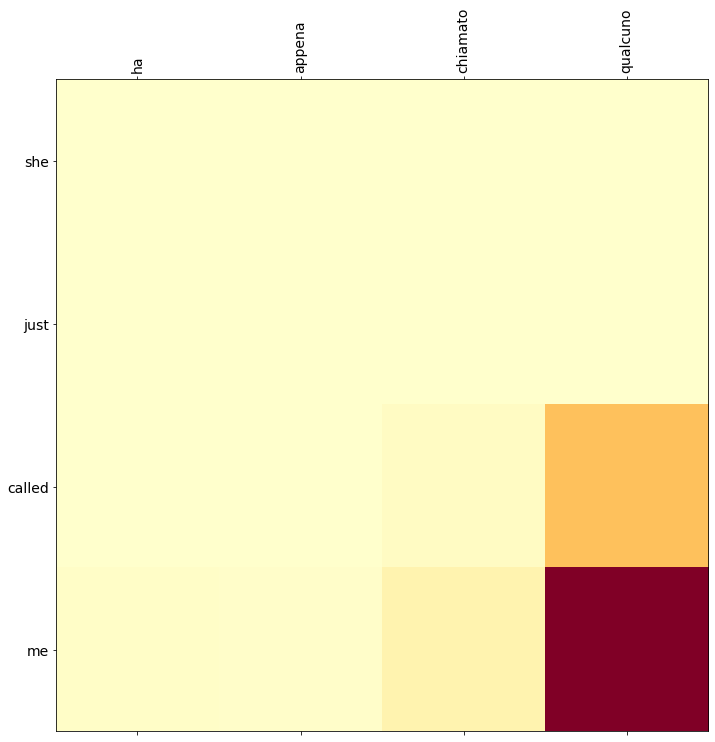

predicted output :  she just called me
actual output : somebody just called


In [47]:
pr_final = train['italin'].values[0][6:-6]
print('input : ', pr_final)
result, attention_plot = predict(pr_final)
attention_plot = attention_plot[:len(result.split(' ')), :len(pr_final.split(' '))]
plot_attention(attention_plot, pr_final.split(' '), result.split(' '))
print('predicted output : ',result)
print('actual output :', train['english'].values[0])

input :  io ero gelosa di voi


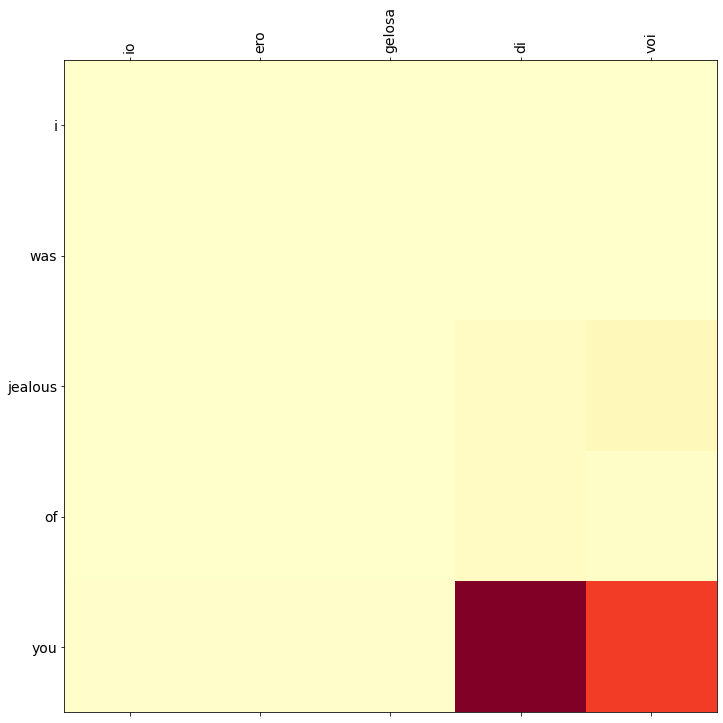

predicted output :  i was jealous of you
actual output : i was jealous of you


In [48]:
pr_final = train['italin'].values[1000][6:-6]
print('input : ', pr_final)
result, attention_plot = predict(pr_final)
attention_plot = attention_plot[:len(result.split(' ')), :len(pr_final.split(' '))]
plot_attention(attention_plot, pr_final.split(' '), result.split(' '))
print('predicted output : ',result)
print('actual output :', train['english'].values[1000])

#### <font color='magenta'>**Calculate BLEU score**</font>

In [49]:
from nltk.translate.bleu_score import sentence_bleu
initial =0
for i in range(1000):
    pr_final = test['italin'].values[i][6:-6]
    con = test['english'].values[i]
    pred = predict(pr_final)
    initial+= sentence_bleu([con.split()], pred.split())
print('Bleu Score : {}'.format(score/1000))

Bleu Score : 0.8262435337297614


<font color='red'>**Repeat the same steps for General scoring function**</font>

In [50]:
from tensorflow.keras.callbacks import*
import os
import datetime

batch_size=128
lstm_size=256
embedding_dim = 100

tr_dat = Dataset(train, tokenizer_italian, tokenizer_english, ita_txt_len, max_len_eng)
te_dat  = Dataset(test, tokenizer_italian, tokenizer_english, ita_txt_len, max_len_eng)
val_dat  = Dataset(validation, tokenizer_italian, tokenizer_english, ita_txt_len, max_len_eng)

train_dataloader = Dataloder(tr_dat, batch_size=batch_size)
test_dataloader = Dataloder(te_dat, batch_size=batch_size)
val_dataloader = Dataloder(val_dat, batch_size = batch_size)

In [51]:
model = encoder_decoder(set_ita_size, set_eng_size, embedding_dim, lstm_size, 
                        lstm_size, ita_txt_len, max_len_eng, 'general', att_units, batch_size)
model.compile(optimizer = 'Adam', loss = loss_function)
log_dir="logs/seq2seq/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") call_back = [ModelCheckpoint('ita_eng_3', save_best_only= True, verbose = 1),
             TensorBoard(log_dir = log_dir, histogram_freq=1, write_graph=True), EarlyStopping(patience = 5, verbose = 1),
             ReduceLROnPlateau(patience = 3, verbose = 1)]

In [52]:
model.fit(x = train_dataloader, steps_per_epoch = train_dataloader.__len__(), validation_data = val_dataloader,
          validation_steps = val_dataloader.__len__(), epochs = 35, verbose = 1, callbacks = call_back)

Epoch 1/35
632/632 [==============================] - 212s 262ms/step - loss: 0.5123 - val_loss: 0.3987

Epoch 00001: val_loss improved from inf to 0.39868, saving model to ita_eng_3
Epoch 2/35
632/632 [==============================] - 148s 235ms/step - loss: 0.3832 - val_loss: 0.3175

Epoch 00002: val_loss improved from 0.39868 to 0.31746, saving model to ita_eng_3
Epoch 3/35
632/632 [==============================] - 149s 236ms/step - loss: 0.3014 - val_loss: 0.2587

Epoch 00003: val_loss improved from 0.31746 to 0.25873, saving model to ita_eng_3
Epoch 4/35
632/632 [==============================] - 148s 235ms/step - loss: 0.2429 - val_loss: 0.2157

Epoch 00004: val_loss improved from 0.25873 to 0.21567, saving model to ita_eng_3
Epoch 5/35
632/632 [==============================] - 149s 235ms/step - loss: 0.1979 - val_loss: 0.1817

Epoch 00005: val_loss improved from 0.21567 to 0.18166, saving model to ita_eng_3
Epoch 6/35
632/632 [==============================] - 148s 234ms/step

In [53]:
final_output = pred_Encoder_decoder(set_ita_size, set_eng_size, embedding_dim, lstm_size, lstm_size, ita_txt_len, max_len_eng, 'general', att_units)
final_output.compile(optimizer = 'Adam', loss = loss_function)
final_output.load_weights('/content/ita_eng_3')

input :  ha appena chiamato qualcuno


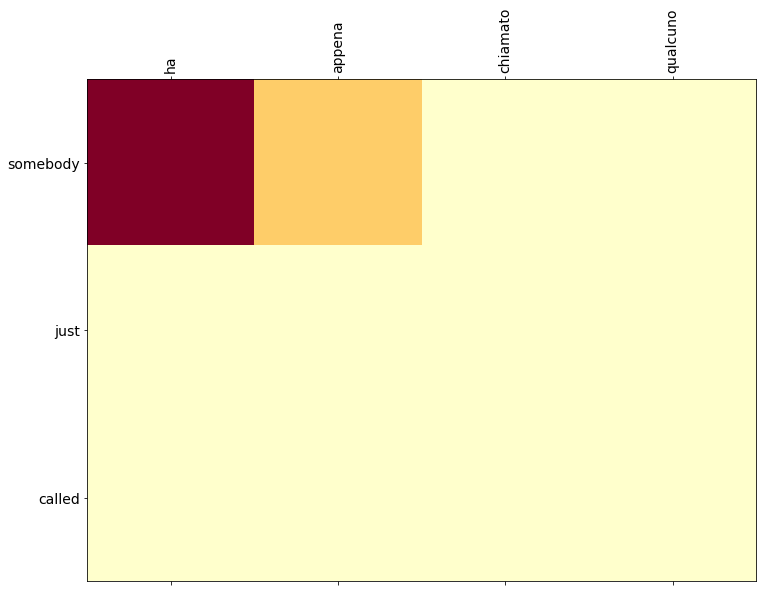

output :  somebody just called


In [54]:
pr_final = train['italin'].values[0][6:-6]
print('input : ', pr_final)
result = predict(pr_final)
print('predicted output : ',result)
print('actual output :', train['english'].values[0])

input :  io ero gelosa di voi


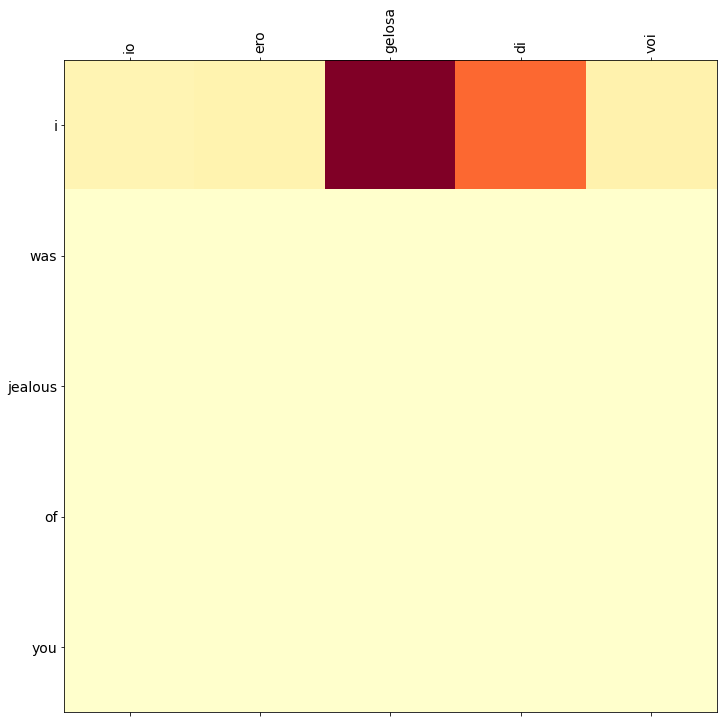

output :  i was jealous of you


In [55]:
pr_final = train['italin'].values[1000][6:-6]
print('input : ', pr_final)
result = predict(pr_final)
print('predicted output : ',result)
print('actual output :', train['english'].values[1000])

In [56]:
from nltk.translate.bleu_score import sentence_bleu
initial =0
for i in range(1000):
    pr_final = test['italin'].values[i][6:-6]
    con = test['english'].values[i]
    pred = predict(pr_final)
    initial+= sentence_bleu([con.split()], pred.split())
print('Bleu Score : {}'.format(score/1000))

Bleu Score : 0.8442320971046736


<font color='red'>**Repeat the same steps for Concat scoring function**</font>

In [57]:
from tensorflow.keras.callbacks import*
import os
batch_size=64
lstm_size=128
embedding_dim = 100

tr_dat = Dataset(train, tokenizer_italian, tokenizer_english, ita_txt_len, max_len_eng)
te_dat  = Dataset(test, tokenizer_italian, tokenizer_english, ita_txt_len, max_len_eng)
val_dat  = Dataset(validation, tokenizer_italian, tokenizer_english, ita_txt_len, max_len_eng)

train_dataloader = Dataloder(tr_dat, batch_size=batch_size)
test_dataloader = Dataloder(te_dat, batch_size=batch_size)
val_dataloader = Dataloder(val_dat, batch_size = batch_size)

In [58]:
model = encoder_decoder(set_ita_size, set_eng_size, embedding_dim, lstm_size, lstm_size, ita_txt_len, max_len_eng, 'concat', att_units, batch_size)
model.compile(optimizer = 'Adam', loss = loss_function)
log_dir="logs/seq2seq/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") call_back = [ModelCheckpoint('ita_eng_4', save_best_only= True),
             TensorBoard(log_dir = log_dir, histogram_freq=1, write_graph=True), EarlyStopping(patience = 5, verbose = 1),
             ReduceLROnPlateau(patience = 3, verbose = 1)]

In [59]:
model.fit(x = train_dataloader, steps_per_epoch = train_dataloader.__len__(), validation_data = val_dataloader,
          validation_steps = val_dataloader.__len__(), epochs = 35, verbose = 1, callbacks = call_back)

Epoch 1/35
1265/1265 [==============================] - 319s 212ms/step - loss: 0.4966 - val_loss: 0.3452
Epoch 2/35
1265/1265 [==============================] - 248s 196ms/step - loss: 0.3225 - val_loss: 0.2693
Epoch 3/35
1265/1265 [==============================] - 247s 195ms/step - loss: 0.2524 - val_loss: 0.2244
Epoch 4/35
1265/1265 [==============================] - 243s 192ms/step - loss: 0.2067 - val_loss: 0.1907
Epoch 5/35
1265/1265 [==============================] - 243s 192ms/step - loss: 0.1704 - val_loss: 0.1637
Epoch 6/35
1265/1265 [==============================] - 240s 190ms/step - loss: 0.1383 - val_loss: 0.1394
Epoch 7/35
1265/1265 [==============================] - 238s 188ms/step - loss: 0.1107 - val_loss: 0.1197
Epoch 8/35
1265/1265 [==============================] - 239s 189ms/step - loss: 0.0873 - val_loss: 0.1049
Epoch 9/35
1265/1265 [==============================] - 242s 192ms/step - loss: 0.0689 - val_loss: 0.0935
Epoch 10/35
1265/1265 [=======================

In [60]:
final_output = pred_Encoder_decoder(set_ita_size, set_eng_size, embedding_dim, lstm_size, lstm_size, ita_txt_len, max_len_eng, 'concat', att_units)
final_output.compile(optimizer = 'Adam', loss = loss_function)
final_output.load_weights('/content/ita_eng_4')

input :  ha appena chiamato qualcuno


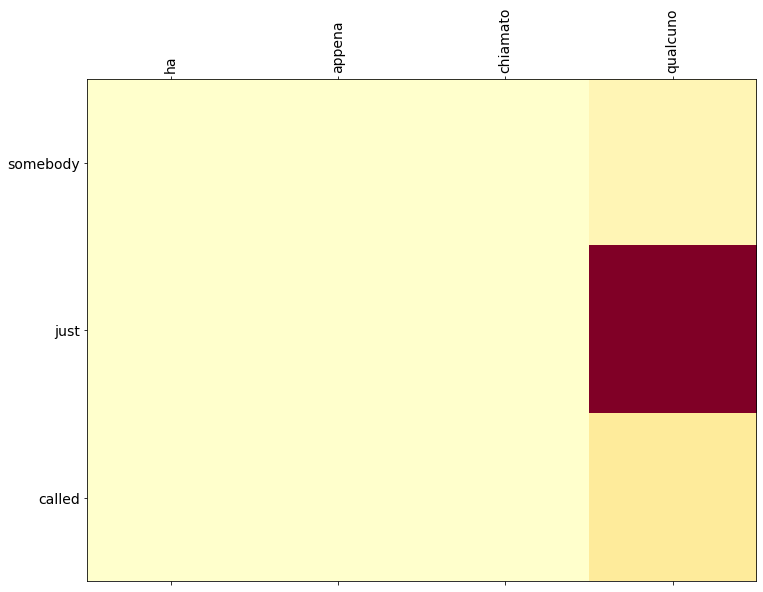

output :  somebody just called


In [61]:
pr_final = train['italin'].values[0][6:-6]
print('input : ', pr_final)
result = predict(pr_final)
print('predicted output : ',result)
print('actual output :', train['english'].values[0])

input :  io ero gelosa di voi


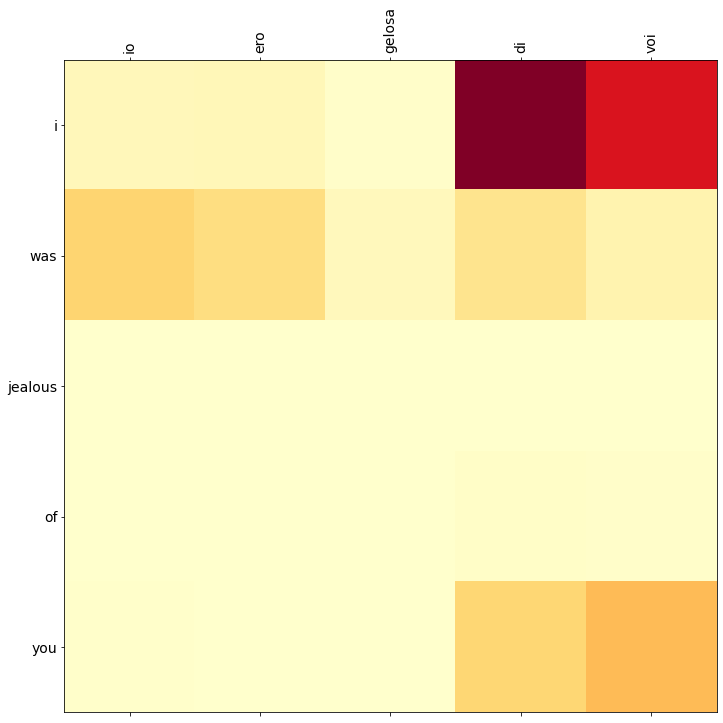

output :  i was jealous of you


In [62]:
pr_final = train['italin'].values[1000][6:-6]
print('input : ', pr_final)
result = predict(pr_final)
print('predicted output : ',result)
print('actual output :', train['english'].values[1000])

In [63]:
from nltk.translate.bleu_score import sentence_bleu
initial =0
for i in range(1000):
    pr_final = test['italin'].values[i][6:-6]
    con = test['english'].values[i]
    pred = predict(pr_final)
    initial+= sentence_bleu([con.split()], pred.split())
print('Bleu Score : {}'.format(score/1000))

Bleu Score : 0.8438060676707472


# Conclusion

* Bleu Score for model-1 is 0.8391122289889017
* Bleu Score for model-2 is 0.8262435337297614 (Attention mechanisum)
* Bleu Score for model-3 is 0.8442320971046736 (General scoring function)
* Bleu Score for model-4 is 0.8438060676707472 (Concat scoring function)